# Week 9 - homework: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [1]:
from termcolor import colored

student_number="1004365"
student_name="Lee Jet Xuen"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Lee Jet Xuen, number: 1004365


In [2]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). In other words: if I input bee, generate me an image of a bee. If I input ant, generate an image of an ant. 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb and the previously mentioned link. 



In [3]:
# Download and unzip images
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

# Combine val and train datasets 
!mkdir -p ./hymenoptera_data/combined/ants
!cp ./hymenoptera_data/val/ants/* ./hymenoptera_data/combined/ants
!cp ./hymenoptera_data/train/ants/* ./hymenoptera_data/combined/ants

!mkdir -p ./hymenoptera_data/combined/bees
!cp ./hymenoptera_data/val/bees/* ./hymenoptera_data/combined/bees
!cp ./hymenoptera_data/train/bees/* ./hymenoptera_data/combined/bees

--2022-07-20 06:23:34--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.229.67, 18.65.229.70, 18.65.229.105, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.229.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  85.1MB/s    in 0.5s    

2022-07-20 06:23:35 (85.1 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/t

In [4]:
# load images and normalize + augment data
'''
Data Augmentation 
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



c) Show a few images from the dataset so we understand what we are working with. 



In [5]:
plt.ion()
plt.rcParams["figure.figsize"] = (15, 60)

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


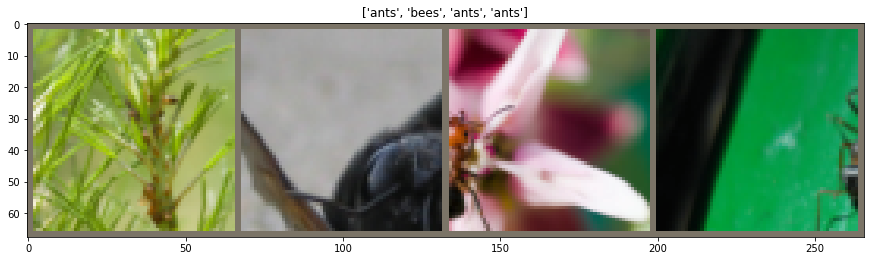

In [7]:
inputs, classes = next(iter(dataloaders['train']))
out = make_grid(inputs)
class_names = image_datasets['train'].classes

imshow(out, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [8]:
# your model here
'''
Discriminator
'''
class Discriminator (nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(20, 20)
        
        self.conv1 = nn.Conv2d(3, 64, 5, 1, 2)
        self.maxpool1 = nn.MaxPool2d(5)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(5)
        self.conv2 = nn.Conv2d(64, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(5)
        self.fc1 = nn.Linear(32*64*64+20, 32)
        self.fc2 = nn.Linear(32, 1)
        
        self.fc3 = nn.Linear (4, 20)
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        x = x.view(batch_size, 3, 64, 64)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        
        x = x.view(batch_size, 32*64*64)
        
        y = self.label_emb(labels)
        y = F.leaky_relu(y, 0.2, inplace=True)
        
        x = torch.cat([x,y],1)
        
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        
        x = self.fc2(x)
        x = torch.sigmoid(x).squeeze()
        
        return x

In [9]:
'''
Generator
'''

class Generator (nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.z_dim = 20
        self.label_emb = nn.Embedding(20, 20)
        
        self.fc1 = nn.Linear(self.z_dim + 20, 32 *64 * 64)
        
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(32 , 64, 5, 1, 2)
        self.maxpool1 = nn.MaxPool2d(3)
        self.bn1 = nn.BatchNorm2d(3)
        self.deconv1 = nn.ConvTranspose2d(64, 3, 5, 1, 2)
        self.maxpool2 = nn.MaxPool2d(3)

    def forward (self, x, labels):
        batch_size = x.size(0)

        y = self.label_emb(labels)
        y = F.leaky_relu(y, 0.2, inplace=True)
        
        x = torch.cat([x,y], 1)
        
        x = self.fc1(x)
        x = x.view(batch_size, 32, 64,64)
        
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.deconv2(x)
        x = self.bn2(x)
        
        
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = self.deconv1(x)
        x = self.bn1(x)
        
        x = torch.sigmoid(x)
        
        return x

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)


e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training. This should be done regularly during training so you can follow the process. 





In [11]:
def discriminator_train_step(batch_size, discriminator,generator, d_optimizer, criterion, real_images, labels):
    discriminator.train()
    generator.train()
    d_optimizer.zero_grad()    
    real_validity = discriminator(real_images,labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    latent = Variable(torch.randn(batch_size, 20)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).to(device)
    fake_images = generator(latent, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # optimize the sum of both losses
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
   
    return d_loss.data

In [12]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    generator.train() # training phase
    g_optimizer.zero_grad()

    latent = Variable(torch.randn(batch_size, 20)).to(device)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 1, batch_size))).to(device)
    fake_images = generator(latent, fake_labels)
    validity = discriminator(fake_images, fake_labels)
   
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
   
    return g_loss.data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 g_loss: 100.0, d_loss: 0.0
['bees', 'bees', 'bees', 'bees']


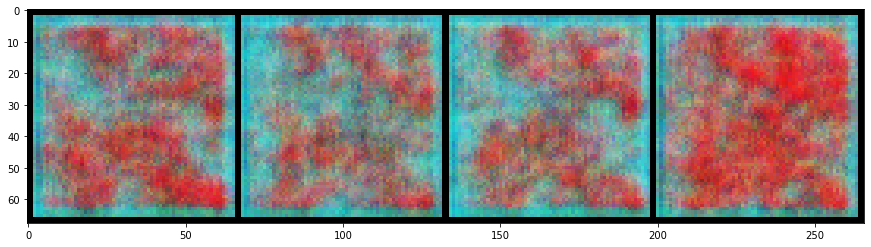

Epoch: 2 g_loss: 100.0, d_loss: 0.0
Epoch: 3 g_loss: 54.19554138183594, d_loss: 0.0
Epoch: 4 g_loss: 100.0, d_loss: 0.0
Epoch: 5 g_loss: 100.0, d_loss: 0.0
Epoch: 6 g_loss: 100.0, d_loss: 0.0
Epoch: 7 g_loss: 100.0, d_loss: 0.0
Epoch: 8 g_loss: 100.0, d_loss: 0.0
Epoch: 9 g_loss: 100.0, d_loss: 0.0
Epoch: 10 g_loss: 100.0, d_loss: 0.0
Epoch: 11 g_loss: 100.0, d_loss: 0.0
Epoch: 12 g_loss: 100.0, d_loss: 0.0
Epoch: 13 g_loss: 100.0, d_loss: 0.0
Epoch: 14 g_loss: 94.13727569580078, d_loss: 0.0
Epoch: 15 g_loss: 100.0, d_loss: 0.0
Epoch: 16 g_loss: 100.0, d_loss: 0.0
Epoch: 17 g_loss: 100.0, d_loss: 0.0
Epoch: 18 g_loss: 100.0, d_loss: 0.0
Epoch: 19 g_loss: 100.0, d_loss: 0.0
Epoch: 20 g_loss: 100.0, d_loss: 0.0
Epoch: 21 g_loss: 96.25395202636719, d_loss: 0.0
['bees', 'bees', 'bees', 'bees']


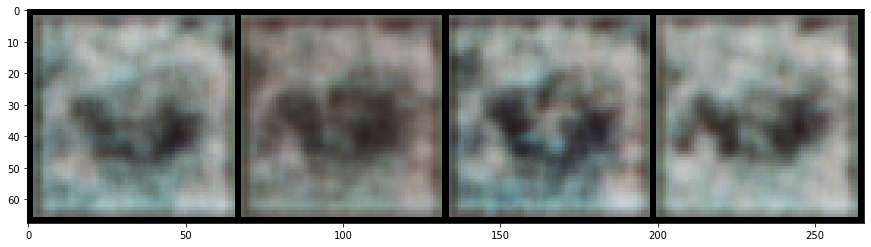

Epoch: 22 g_loss: 100.0, d_loss: 0.0
Epoch: 23 g_loss: 100.0, d_loss: 0.0
Epoch: 24 g_loss: 100.0, d_loss: 0.0
Epoch: 25 g_loss: 100.0, d_loss: 0.0
Epoch: 26 g_loss: 100.0, d_loss: 0.0
Epoch: 27 g_loss: 100.0, d_loss: 0.0
Epoch: 28 g_loss: 100.0, d_loss: 0.0
Epoch: 29 g_loss: 96.34404754638672, d_loss: 0.0
Epoch: 30 g_loss: 100.0, d_loss: 0.0
Epoch: 31 g_loss: 100.0, d_loss: 0.0
Epoch: 32 g_loss: 100.0, d_loss: 25.0
Epoch: 33 g_loss: 0.0, d_loss: 100.0
Epoch: 34 g_loss: 0.0, d_loss: 100.0
Epoch: 35 g_loss: 0.0, d_loss: 100.0
Epoch: 36 g_loss: 0.0, d_loss: 100.0
Epoch: 37 g_loss: 0.0, d_loss: 100.0
Epoch: 38 g_loss: 0.0, d_loss: 100.0
Epoch: 39 g_loss: 0.0, d_loss: 100.0
Epoch: 40 g_loss: 0.0, d_loss: 100.0
Epoch: 41 g_loss: 0.0, d_loss: 100.0
['bees', 'ants', 'ants', 'bees']


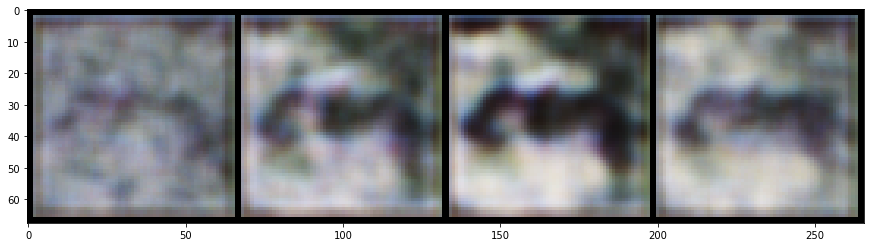

Epoch: 42 g_loss: 0.0, d_loss: 100.0
Epoch: 43 g_loss: 0.0, d_loss: 100.0
Epoch: 44 g_loss: 0.0, d_loss: 100.0
Epoch: 45 g_loss: 0.0, d_loss: 100.0
Epoch: 46 g_loss: 0.0, d_loss: 100.0
Epoch: 47 g_loss: 0.0, d_loss: 100.0
Epoch: 48 g_loss: 0.0, d_loss: 100.0
Epoch: 49 g_loss: 0.0, d_loss: 100.0
Epoch: 50 g_loss: 0.0, d_loss: 100.0
Epoch: 51 g_loss: 0.0, d_loss: 100.0
Epoch: 52 g_loss: 0.0, d_loss: 100.0
Epoch: 53 g_loss: 0.0, d_loss: 100.0
Epoch: 54 g_loss: 0.0, d_loss: 100.0
Epoch: 55 g_loss: 0.0, d_loss: 100.0
Epoch: 56 g_loss: 0.0, d_loss: 100.0
Epoch: 57 g_loss: 0.0, d_loss: 100.0
Epoch: 58 g_loss: 0.0, d_loss: 100.0
Epoch: 59 g_loss: 0.0, d_loss: 100.0
Epoch: 60 g_loss: 0.0, d_loss: 100.0
Epoch: 61 g_loss: 0.0, d_loss: 100.0
['ants', 'ants', 'ants', 'ants']


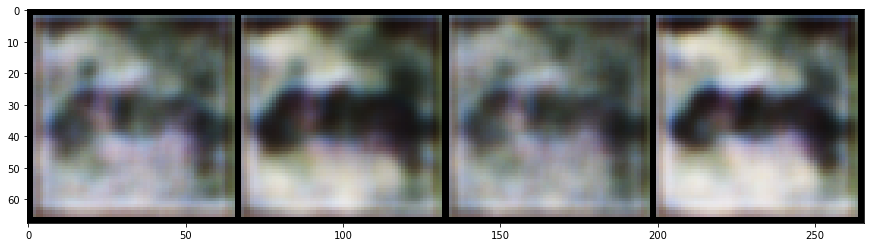

Epoch: 62 g_loss: 0.0, d_loss: 100.0
Epoch: 63 g_loss: 0.0, d_loss: 100.0
Epoch: 64 g_loss: 0.0, d_loss: 100.0
Epoch: 65 g_loss: 0.0, d_loss: 100.0
Epoch: 66 g_loss: 0.0, d_loss: 100.0
Epoch: 67 g_loss: 0.0, d_loss: 100.0
Epoch: 68 g_loss: 0.0, d_loss: 100.0
Epoch: 69 g_loss: 0.0, d_loss: 100.0
Epoch: 70 g_loss: 0.0, d_loss: 100.0
Epoch: 71 g_loss: 0.0, d_loss: 100.0
Epoch: 72 g_loss: 0.0, d_loss: 100.0
Epoch: 73 g_loss: 0.0, d_loss: 100.0
Epoch: 74 g_loss: 0.0, d_loss: 100.0
Epoch: 75 g_loss: 0.0, d_loss: 100.0
Epoch: 76 g_loss: 0.0, d_loss: 100.0
Epoch: 77 g_loss: 0.0, d_loss: 100.0
Epoch: 78 g_loss: 0.0, d_loss: 100.0
Epoch: 79 g_loss: 0.0, d_loss: 100.0
Epoch: 80 g_loss: 0.0, d_loss: 100.0
Epoch: 81 g_loss: 0.0, d_loss: 100.0
['bees', 'ants', 'ants', 'ants']


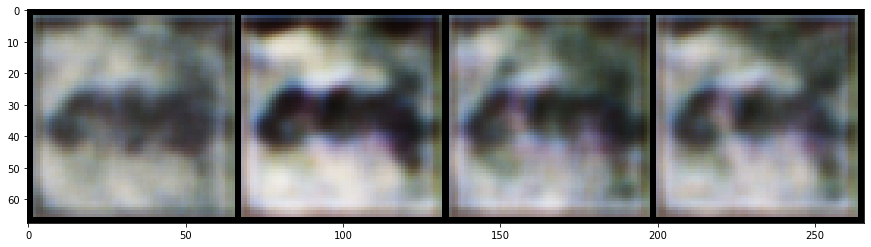

Epoch: 82 g_loss: 0.0, d_loss: 100.0
Epoch: 83 g_loss: 0.0, d_loss: 100.0
Epoch: 84 g_loss: 0.0, d_loss: 100.0
Epoch: 85 g_loss: 0.0, d_loss: 100.0
Epoch: 86 g_loss: 0.0, d_loss: 100.0
Epoch: 87 g_loss: 0.0, d_loss: 100.0
Epoch: 88 g_loss: 0.0, d_loss: 100.0
Epoch: 89 g_loss: 0.0, d_loss: 100.0
Epoch: 90 g_loss: 0.0, d_loss: 100.0
Epoch: 91 g_loss: 0.0, d_loss: 100.0
Epoch: 92 g_loss: 0.0, d_loss: 100.0
Epoch: 93 g_loss: 0.0, d_loss: 100.0
Epoch: 94 g_loss: 0.0, d_loss: 100.0
Epoch: 95 g_loss: 0.0, d_loss: 100.0
Epoch: 96 g_loss: 0.0, d_loss: 100.0
Epoch: 97 g_loss: 0.0, d_loss: 100.0
Epoch: 98 g_loss: 0.0, d_loss: 100.0
Epoch: 99 g_loss: 0.0, d_loss: 100.0
Epoch: 100 g_loss: 0.0, d_loss: 100.0


In [13]:
# train
epochs = 100

from tqdm import tqdm

for i in range(epochs):
    for idx, (image, labels) in enumerate(dataloaders['train']):
            
        real_images = image.to(device)
        labels = labels.to(device)
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
    generator.eval()
    print(f'Epoch: {i+1} g_loss: {g_loss}, d_loss: {d_loss}')

    if i %20 == 0:
      z = Variable(torch.randn(4, 20)).to(device)
      
      labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).to(device)
      classes = [class_names[l] for l in labels]
      sample_images = generator(z, labels).data.cpu()
      
      grid = make_grid(sample_images).permute(1,2,0).numpy()
      print(classes)
      plt.imshow(grid)
      plt.show()

g) Showcase how your model can now take an input option and generate the appropriate image. Show this for both ants and bees. 

['ants', 'ants', 'ants', 'bees']


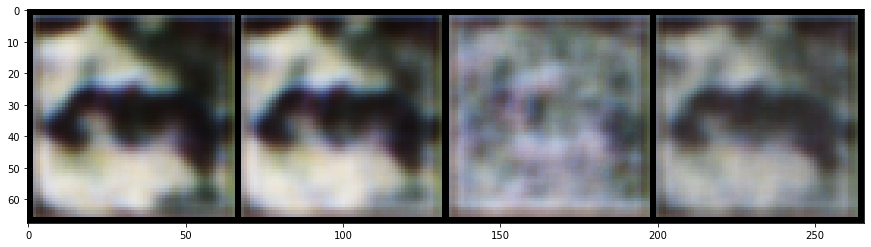

In [14]:
latent = Variable(torch.randn(4, 20)).to(device)
      
labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).to(device)
classes = [class_names[i] for i in labels]
sample_images = generator(latent, labels).data.cpu()
      
grid = make_grid(sample_images).permute(1,2,0).numpy()
print(classes)
plt.imshow(grid)
plt.show()

h) Does this model work well enough? What might be the reason for this? Do you have any suggestions for improvement? 


In [17]:
# answer

No the model doesn't work well enough.

The reason maybe because of the training data, background of the training data is not standardized. As such there is little information to learn about the image of the insect itself。

To train the model, we might need a larger and good enough model dataset for the model to learnt he fetures of the ants and bees.

i) Is the loss function enough to assess the quality of the images? If not, how could you improve the evaluation? 

In [16]:
# answer

No. rating of the generated images could be used to improve the evaluation